## Import Libraries

In [588]:
import time
import math
import copy
import numpy as np
import sys
import copy
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

# Import convex optimization library
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

import seaborn as sns
import matplotlib.pyplot as plt     

In [589]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.3.


## Preprocessing

In [590]:
class Preprocessing:
    def __init__(self):
        self.numerical_features_name_list_including_labels = None
        self.categorical_features_namelist = None
        #self.scaler_used_for_features = scaler_used_for_features
        self.labels = None
    
    
    
    
    #Custom train_test_split indices generator
    def train_test_split_indices(self, len_data, test_split_size):
        
        #Note that if a sample is to be dropped because of too many missing features, it should be done before this step.
        np.random.seed(42)
        shuffled_data_indices = np.random.permutation(len_data)
        total_test_data = int(test_split_size * len_data)
        testing_indices = shuffled_data_indices[:total_test_data]
        training_indices = shuffled_data_indices[total_test_data:]
        return training_indices, testing_indices
    
    
    def set_numerical_and_categorical_feature_names(self, dataframe):
        
        #get the names of the numeric feature columns only
        self.numerical_features_name_list_including_labels = dataframe.select_dtypes(include=np.number).columns.tolist()
        #get the names of the categorical feature columns only
        list_of_categorical_feature_names = []
        for feature in dataframe.columns:
            if dataframe.dtypes[feature] == "object":
                
                list_of_categorical_feature_names.append(feature)
        self.categorical_features_namelist = list_of_categorical_feature_names
        

## Dual SVM Implementation with QP Solver

In [591]:
def SVM_Kernel(kernel_type, X):
    
    
    if kernel_type == "Linear":
        gram_matrix = np.matmul(X.values, X.T.values)
        return gram_matrix
    else:
        raise ValueError
    

class Dual_SVM(BaseEstimator, ClassifierMixin):
    
    def __init__(self, learning_rate = 0.0001, c = 0., kernel = "Linear"):
        
        self.learning_rate = learning_rate
        self.c = c
        self.kernel_type = kernel
        self.alphas = None
        self.non_zero_alpha_indices = None
        
    
    def fit(self, X, y = None):
        '''
        Train SVM in its dual form using a quadratic solver
        
        Parameters
        -----------------------
        X : arraylike
            The training samples in 2D format, corresponding to input features of each sample
            to train the vanilla SVM model in its dual form.
        y : arraylike, optional, default None
            The labels for each sample in X. Some algorithms do not require the label y while some (like SVM) do.
            Hence, keep y as optional.
        
        Returns
        ----------------
        self : Trained Dual_SVM object
               This method returns self for compatibility reasons with sklearn's other interfaces/ functionalities.
        
        '''
        
        assert type(self.c) == float or type(self.c) == int, "Data type of parameter c is invalid."
        assert self.c >= 0 and self.c <= sys.maxsize, "Value of parameter c is out of possible range."
        
        
        # Convert into cvxopt standard format for the qp solver of cvxopt
        no_of_tr_samples , no_of_tr_features = X.shape
        A = cvxopt_matrix(y.values.reshape((1,-1)))
        #print("typecode: {}".format(A.typecode))   <-- data type wasnt float, so convert into float
        A = cvxopt_matrix(A, (1, no_of_tr_samples), 'd')   
        G = cvxopt_matrix(-1 * np.identity(no_of_tr_samples))
        b = cvxopt_matrix([[0]])
        b = cvxopt_matrix(b, (1,1),"d")
        
        h = cvxopt_matrix(np.zeros((no_of_tr_samples,1)))
        q = cvxopt_matrix(cvxopt_matrix(-np.ones((no_of_tr_samples, 1))))
        P = cvxopt_matrix(SVM_Kernel(self.kernel_type, X))
        
        
        
        
        # Pass the arguments to the qp solver
        dual_solution = cvxopt_solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(dual_solution['x'])
        self.non_zero_alpha_indices = (self.alphas > 1e-4).flatten()
        support_vectors_features = X[self.non_zero_alpha_indices]
        support_vectors_labels = y[self.non_zero_alpha_indices]
#         alphas = alphas[non_zero_alpha_indices]
        
        # compute w and b
        
        temp = np.multiply(y, self.alphas).values.reshape(-1,1)
        
        self.w = w = ((y * self.alphas).T @ X).values.reshape(-1,1)#np.multiply(temp, X).values.reshape(-1,1)
        assert self.w.shape[0] == no_of_tr_features

        

        #Computing b (we'll take the average b value to make it more stable as suggested by Bishop)
        S = (self.alphas > 1e-4).flatten()
        all_b_vals = y.values[S] - np.dot(X.values[S], self.w)#y.values[self.non_zero_alpha_indices] - np.dot(X.values[self.non_zero_alpha_indices], w)
        self.b = np.sum(all_b_vals) / len(all_b_vals)
        
        #Display results
        print('\nNon-zeo alphas : ',self.alphas[self.non_zero_alpha_indices])
        print('w : ', self.w.flatten())
        print('b : ', self.b)
        
    def predict_a_sample(self, test_sample):
        
        pred = np.dot(test_sample, self.w) + self.b
        if pred > 0:
            return 1
        else:
            return -1
        
        
        
    
    

In [592]:
#lets see what unique classes are present.
raw_data["Species"].unique()

array([ 1, -1], dtype=int64)

In [593]:
path = r"C:\Users\Being_Aerys\PycharmProjects\Machine_Learning_Algorithms_Collection\Supervised_Methods\Support_Vector_Machines\data\Iris.csv"
raw_data = pd.read_csv(path, sep = ",")
raw_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [594]:
#Convert the class labels into +1 and -1 as required by the SVM for mathematical ease

raw_data = raw_data.replace(["Iris-setosa"],1)
raw_data = raw_data.replace(["Iris-versicolor", "Iris-virginica"],-1)
raw_data = raw_data.drop("Id", 1)
raw_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [595]:
#maintain a fresh copy of the data set for future use
copy_of_raw_data = copy.deepcopy(raw_data)

In [596]:
preprocessing = Preprocessing()

training_indices, testing_indices = preprocessing.train_test_split_indices(len(raw_data), 0.2)
train_set, test_set = raw_data.iloc[training_indices], raw_data.iloc[testing_indices]
preprocessing.set_numerical_and_categorical_feature_names(train_set)

train_set.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
22,4.6,3.6,1.0,0.2,1
15,5.7,4.4,1.5,0.4,1
65,6.7,3.1,4.4,1.4,-1
11,4.8,3.4,1.6,0.2,1
42,4.4,3.2,1.3,0.2,1


In [597]:
#As seen above, the data set indices have changed and we should reset the indices for ease.
train_set.reset_index(inplace = True)
train_set = train_set.drop("index", 1)
train_set.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,4.6,3.6,1.0,0.2,1
1,5.7,4.4,1.5,0.4,1
2,6.7,3.1,4.4,1.4,-1
3,4.8,3.4,1.6,0.2,1
4,4.4,3.2,1.3,0.2,1


In [598]:
#Separate training features and labels
train_features = train_set[train_set.columns[~train_set.columns.isin(["Species"])]]
train_labels = pd.DataFrame(train_set["Species"]) #convert to dataframe since a single column becomes a pandas Series

In [599]:
#Summarize the information of the training set
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
SepalLengthCm    120 non-null float64
SepalWidthCm     120 non-null float64
PetalLengthCm    120 non-null float64
PetalWidthCm     120 non-null float64
dtypes: float64(4)
memory usage: 3.8 KB


In [600]:
#Lets instantiate the SVM estimator that we defined and train the model using the training set.
hard_dual_svm = Dual_SVM()

### Fit

In [601]:
#fit SVM using the training set
hard_dual_svm.fit(X = train_features, y = train_labels)

     pcost       dcost       gap    pres   dres
 0: -9.4272e-01 -1.1998e+00  2e+02  1e+01  1e+00
 1: -5.5570e-02 -9.7417e-02  4e+00  3e-01  3e-02
 2: -7.3037e-03 -4.9825e-02  3e-01  2e-02  2e-03
 3: -4.7167e-03 -3.3185e-02  3e-02  4e-18  7e-16
 4: -1.1118e-02 -1.5326e-02  4e-03  9e-19  4e-16
 5: -1.2287e-02 -1.6104e-02  4e-03  3e-18  3e-16
 6: -1.4731e-02 -1.5104e-02  4e-04  4e-18  3e-16
 7: -1.4963e-02 -1.5011e-02  5e-05  3e-18  3e-16
 8: -1.5000e-02 -1.5005e-02  6e-06  5e-18  3e-16
 9: -1.5004e-02 -1.5004e-02  3e-07  2e-18  3e-16
10: -1.5004e-02 -1.5004e-02  1e-08  5e-18  3e-16
Optimal solution found.

Non-zeo alphas :  [[0.00145818]
 [0.01500396]
 [0.01354578]]
w :  [-0.00614741 -0.00091712 -0.03029958 -0.01050278]
b :  -0.21191653635876354


### Predict

In [602]:
#Separate training features and labels
test_features = test_set[test_set.columns[~test_set.columns.isin(["Species"])]]
test_labels = pd.DataFrame(test_set["Species"]) #convert to dataframe since a single column becomes a pandas Series
test_labels.reset_index(inplace = True)
test_labels = test_labels.drop("index", 1)
test_labels

,Species
0,-1
1,1
2,-1
3,-1
4,-1
5,1
6,-1
7,-1
8,-1
9,-1


In [603]:
test_preds = []
for idx in range(0, len(test_features)):
    
    test_preds.append(hard_dual_svm.predict_a_sample(test_features.iloc[idx] ))

In [604]:
test_preds = pd.DataFrame(test_preds)
test_preds

,0
0,-1
1,-1
2,-1
3,-1
4,-1
5,-1
6,-1
7,-1
8,-1
9,-1


In [605]:
combined = test_labels
combined

,Species
0,-1
1,1
2,-1
3,-1
4,-1
5,1
6,-1
7,-1
8,-1
9,-1


In [606]:
combined = combined.rename(columns={"Species": "true_values",})

In [607]:
combined = combined.assign(predicted_values = test_preds)

In [608]:
combined

,true_values,predicted_values
0,-1,-1
1,1,-1
2,-1,-1
3,-1,-1
4,-1,-1
5,1,-1
6,-1,-1
7,-1,-1
8,-1,-1
9,-1,-1


In [609]:
test_accuracy_individual = [1 if combined["true_values"].values[idx] == combined["predicted_values"].values[idx] else 0 for idx in range(0,len(combined))]

In [610]:

test_accuracy = (sum(test_accuracy_individual)/ len(test_preds)) * 100
test_accuracy

66.66666666666666

In [611]:
labels_in_sorted_order = [-1,1] # Species in sorted order --> -1, 1
conf_matrix = metrics.confusion_matrix(test_labels, test_preds, labels_in_sorted_order)
conf_matrix

array([[20,  0],
       [10,  0]], dtype=int64)

[Text(0, 0.5, '-1'), Text(0, 1.5, '1')]

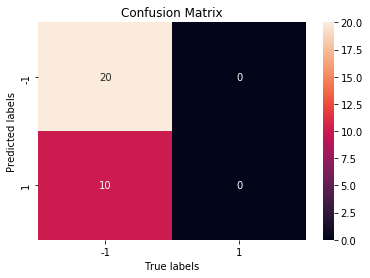

In [612]:
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels_in_sorted_order)
ax.yaxis.set_ticklabels(labels_in_sorted_order)

As seen above, the hard margin SVM is unable to predict correctly for all the sample of class 1. <br>Soft margin can be introduced to allow the SVM to allow some flexibility in the margin. For this, c parameter gets introduced to one of the dual constraints. This should be used in the h matrix of cvxopt qp solver. <br>Or a kernel can be used to map the features into a higher dimension where the samples are easily separable by a linear margin.